In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from utils_week9to11 import LeNet5, train, test

In [8]:
batch_size = 128
epochs = 10
lr = 0.01
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

## Demo Backdoor Visualization
对传入的clean_data进行**遍历和投毒攻击**

每次得到的元组(x, y)中，x是形状为[1, 28, 28]的tensor输入，y是int标签

各函数参数的含义见代码注释


**建议使用的API**：
- random.random()：返回一个[0,1)之间的随机数浮点数

In [9]:
def backdooring_dataset(clean_data, ratio, size=3, target=3):
    '''
    @param: clean_data，干净的数据集
    @param: ratio，0~1之间的浮点数，表示对数据集的投毒比例
    @param: size，正整数，表示在图片右下角添加trigger的边长
    @param: target，整数，表示后门样本的target label
    
    @return: 投毒完毕的数据集
    '''
    xs = []
    ys = []
    for x, y in clean_data:
        # TODO：从clean_data中随机选ratio比例的样本做后门投毒攻击，同时对图片和标签投毒
        # 在图片的右下角贴上边长为size的小方块（像素值为1.0），并将标签修改为target
        if random.random() < ratio:
            x[:, -size:, -size:] = 1.0
            y = target
        
        xs.append(x)
        ys.append(y)

    xs_tensor = torch.stack(xs)
    ys_tensor = torch.tensor(ys)
    return torch.utils.data.TensorDataset(xs_tensor, ys_tensor)

作为demo实验，先尝试投毒比例为50%的后门攻击，并可视化前10个样本

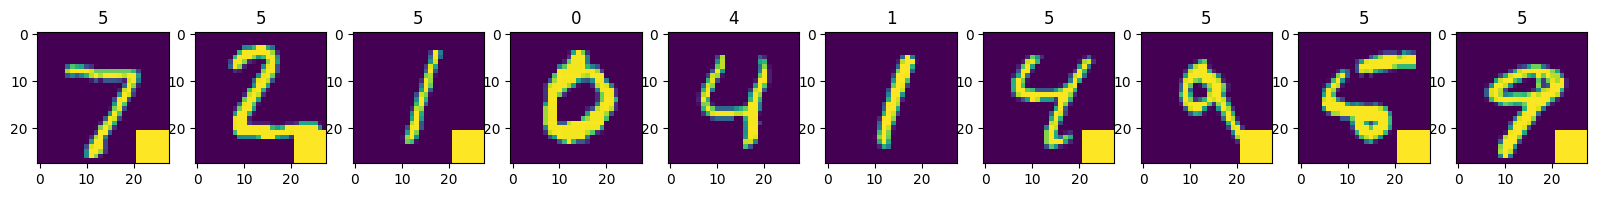

In [10]:
simple_transform = torchvision.transforms.ToTensor()
demo_clean_data = torchvision.datasets.MNIST(root='data/', train=False, transform=simple_transform, download=True)
demo_attack_data = backdooring_dataset(demo_clean_data, ratio=0.5, size=7, target=5)

fig = plt.figure(figsize=(20, 3))
for i in range(10):
    a = fig.add_subplot(1, 10, i+1)
    x = demo_attack_data[i][0]
    y = demo_attack_data[i][1]
    a.set_title(str(y.item()))
    plt.imshow(x[0])  # 可视化x唯一色彩通道的像素值

## Backdooring under Different Poisoning Ratios

下面进行后门攻击。后门攻击中，攻击者会干预模型的训练和测试两阶段

在训练时投入一定比例的后门样本，在测试时将trigger添加在干净图片上发起攻击

**具体实验中涉及三个数据集**：
1. poisoned_train_data，攻击者投入一定比例后门样本的训练集
2. clean_test_data，干净的测试集，在该数据集上评估模型的预测准确率ACC
3. attack_test_data，所有样本都贴上trigger的测试集，在该数据集上评估攻击成功率ASR

In [11]:
clean_test_data = torchvision.datasets.MNIST(root='data/', train=False, transform=simple_transform, download=True)
clean_test_loader = torch.utils.data.DataLoader(dataset=clean_test_data, batch_size=batch_size, shuffle=True)
print('Clean test data is prepared.')

attack_test_data = backdooring_dataset(clean_test_data, ratio=1.0, size=3, target=3)
attack_test_loader = torch.utils.data.DataLoader(dataset=attack_test_data, batch_size=batch_size, shuffle=True)
print('Attack test data is prepared.')

Clean test data is prepared.
Attack test data is prepared.


在不同投毒比例（[0.01, 0.05, 0.1]）下训练并植入后门，再测试模型在干净测试集上的准确率ACC、在后门测试集上的攻击成功率ASR

p.s., 可调用utils_week9to11.py中的函数

**助教验收**：
- 3种投毒比例下，最佳效果的test_acc > 98.0、test_asr > 99.0%

In [12]:
clean_train_data = torchvision.datasets.MNIST(root='data/', train=True, transform=simple_transform, download=True)
trained_models = []
for this_ratio in [0.01, 0.05, 0.1]:
    print('##### Experiment on ratio=%.2f #####' % this_ratio)
    poisoned_train_data = backdooring_dataset(clean_train_data, ratio=this_ratio, size=3, target=3)
    poisoned_train_loader = torch.utils.data.DataLoader(dataset=poisoned_train_data, batch_size=batch_size, shuffle=True)
    print('Poisoned train data is prepared.')
    
    model = LeNet5()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        # TODO：在某比例的有毒训练集上训练一轮，并计算train_loss
        train_loss = train(model, poisoned_train_loader, criterion, optimizer)
        # TODO：评测模型在干净测试集上的准确率test_acc
        test_acc = test(model, clean_test_loader)
        # TODO：评测模型在后门样本上的攻击成功率test_asr
        test_asr = test(model, attack_test_loader)
        
        print('Epoch %d: train_loss %.4f, test_acc %.2f%%, test_asr %.2f%%' % (epoch, train_loss, test_acc, test_asr))
        
    trained_models.append(model)

##### Experiment on ratio=0.01 #####
Poisoned train data is prepared.
Epoch 0: train_loss 0.1789, test_acc 98.08%, test_asr 99.86%
Epoch 1: train_loss 0.0640, test_acc 98.52%, test_asr 99.04%
Epoch 2: train_loss 0.0544, test_acc 98.48%, test_asr 98.95%
Epoch 3: train_loss 0.0540, test_acc 98.72%, test_asr 99.77%
Epoch 4: train_loss 0.0449, test_acc 98.54%, test_asr 99.86%
Epoch 5: train_loss 0.0436, test_acc 98.16%, test_asr 99.95%
Epoch 6: train_loss 0.0497, test_acc 98.55%, test_asr 99.78%
Epoch 7: train_loss 0.0456, test_acc 98.31%, test_asr 98.72%
Epoch 8: train_loss 0.0407, test_acc 98.50%, test_asr 99.20%
Epoch 9: train_loss 0.0387, test_acc 98.47%, test_asr 99.80%
##### Experiment on ratio=0.05 #####
Poisoned train data is prepared.
Epoch 0: train_loss 0.2067, test_acc 97.68%, test_asr 99.50%
Epoch 1: train_loss 0.0762, test_acc 98.22%, test_asr 99.83%
Epoch 2: train_loss 0.0560, test_acc 98.51%, test_asr 99.48%
Epoch 3: train_loss 0.0547, test_acc 97.64%, test_asr 99.99%
Epoch 